In [1]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from mpl_toolkits import mplot3d 

# Data Import

In [4]:
data = pd.read_csv("data2012.csv")
data = data.drop('fid',axis=1)
data.head()

,country,fua_name,road_len,area,population,city_pop,cen_dist,night,land_cover,X,Y,city_id
0,PT,Lisboa,0.000000,669832.232177,0.0,2815535,38.606784,1.0300,11,-9.505698,38.784757,21
1,PT,Lisboa,0.000000,669755.214578,0.0,2815535,37.800579,0.7550,11,-9.497365,38.793090,21
2,PT,Lisboa,1.027019,669832.232177,0.0,2815535,37.685759,2.2275,11,-9.497365,38.784757,21
3,PT,Lisboa,0.083511,669909.235391,0.0,2815535,37.592849,2.1775,11,-9.497365,38.776424,21
4,PT,Lisboa,0.000000,669986.224222,0.0,2815535,37.522009,0.7500,11,-9.497365,38.768090,21


In [6]:
alist = data.columns.to_list()
alist

['country',
 'fua_name',
 'road_len',
 'area',
 'population',
 'city_pop',
 'cen_dist',
 'night',
 'land_cover',
 'X',
 'Y',
 'city_id']

In [8]:
alist = [ 'population',  'night', 'road_len', 'land_cover', 'city_pop', 'cen_dist', 'X', 'Y', 'country', 'fua_name']
data = data[alist]
data.describe()

,population,night,road_len,land_cover,city_pop,cen_dist,X,Y
count,260534.000000,260534.000000,260534.000000,260534.000000,2.605340e+05,260534.000000,260534.000000,260534.000000
mean,573.218713,4.625352,2.618643,6.632543,4.394432e+06,48.840822,9.948661,49.823713
std,2237.603599,12.620485,3.395864,2.135577,3.148661e+06,26.506507,8.835994,5.054657
min,0.000000,0.000000,0.000000,1.000000,1.207469e+06,0.088187,-9.505698,38.409757
25%,0.000000,0.347500,0.079500,7.000000,2.120416e+06,29.361106,2.452635,47.718090
50%,10.003517,0.712500,1.553339,7.000000,2.939714e+06,44.830977,12.369302,50.759757
75%,125.796494,2.750000,3.376450,8.000000,4.814757e+06,63.796209,16.669302,52.701424
max,58890.018027,1361.780000,40.156530,11.000000,1.166596e+07,166.826791,26.460969,60.259757


## Data Analysis

In [10]:
data['land_cover'].value_counts()

7     141809
8      56523
2      32117
11      9572
3       5025
9       4971
6       4245
1       2056
4       1695
10      1381
5       1140
Name: land_cover, dtype: int64

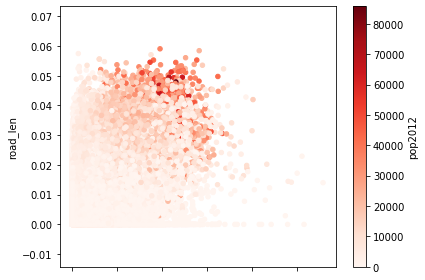

In [20]:
# Show the population distribution in Roma
data.plot(kind='scatter', x='night', y='road_len', alpha=1, c='pop2012',cmap='Reds')
plt.tight_layout()

In [11]:
# Compute pairwise correlation of columns
data.corr()

,population,night,road_len,land_cover,city_pop,cen_dist,X,Y
population,1.000000,0.604888,0.635437,-0.494418,0.118273,-0.276676,-0.085802,-0.057597
night,0.604888,1.000000,0.537351,-0.463503,0.136643,-0.337221,-0.160841,-0.166312
road_len,0.635437,0.537351,1.000000,-0.700589,0.102320,-0.355035,-0.111823,-0.029019
land_cover,-0.494418,-0.463503,-0.700589,1.000000,-0.145731,0.297494,0.085220,0.077119
city_pop,0.118273,0.136643,0.102320,-0.145731,1.000000,0.116173,-0.455115,-0.129343
cen_dist,-0.276676,-0.337221,-0.355035,0.297494,0.116173,1.000000,0.090790,0.251329
X,-0.085802,-0.160841,-0.111823,0.085220,-0.455115,0.090790,1.000000,0.270831
Y,-0.057597,-0.166312,-0.029019,0.077119,-0.129343,0.251329,0.270831,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEE1A5D408>,
      dtype=object)

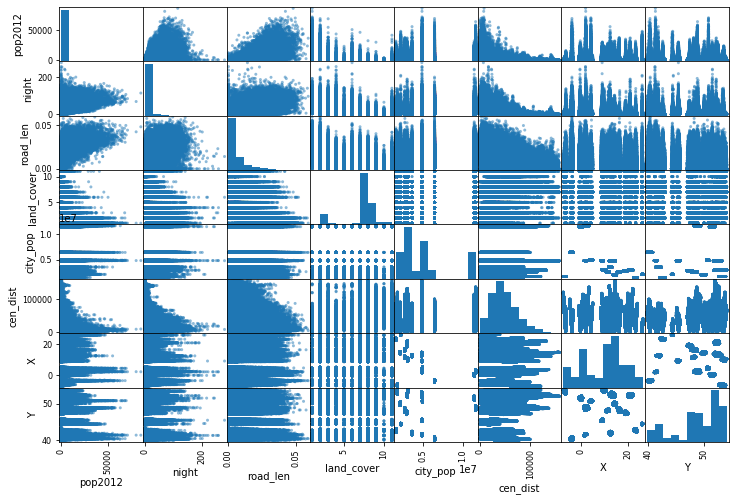

In [34]:
scatter_matrix(data,figsize=(12,8))

In [35]:
def density_scatter(x, y, label, ax=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), \
            data , np.vstack([x,y]).T, method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

In [36]:
x = data['road_len'].to_numpy()
y = data['night'].to_numpy()
z = data['pop2012'].to_numpy()

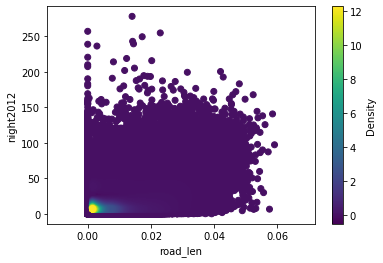

In [37]:
# 2D Version
density_scatter(x, y, label=('road_len','night2012'), bins=[20,20])

In [38]:
# %matplotlib notebook
# # calling it a second time may prevent some graphics errors
# %matplotlib notebook 

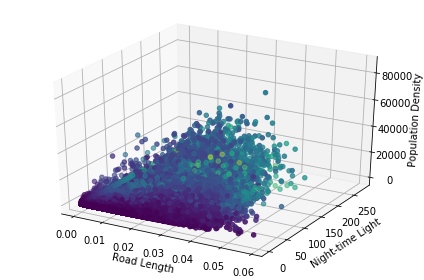

In [39]:
# 3D Version
label=('Road Length','Night-time Light','Population Density')

fig = plt.figure()
ax = plt.axes(projection='3d') 

X, Y, Z = x, y, z
c = (X + Y) * 2

ax.scatter(X, Y, Z, c=c)
ax.set_xlabel(label[0])
ax.set_ylabel(label[1])
ax.set_zlabel(label[2])
# ax.set_xlim([0, 0.75])
# ax.set_zlim([0, 0.75])

# ax.set_title('3D Scatter Plot') 
plt.tight_layout()

## Temporary steps (Un-used for now)

In [9]:
file = "2012.csv"
data = pd.read_csv(file)
data['pop_sum'] = data.groupby(['fua_name'])['population'].transform(sum)
data['X_cen_temp'] = data['X'] * data['population'] / data['pop_sum']
data['Y_cen_temp'] = data['Y'] * data['population'] / data['pop_sum']
data['X_cen'] = data.groupby(['fua_name'])['X_cen_temp'].transform(sum)
data['Y_cen'] = data.groupby(['fua_name'])['Y_cen_temp'].transform(sum)

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + \
        np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [11]:
data['cen_dist'] = haversine(data['X'],data['Y'],data['X_cen'],data['Y_cen'])

In [12]:
data.head()

,X,Y,fid,country,fua_name,road_len,area,population,city_pop,pop_sum,X_cen_temp,Y_cen_temp,X_cen,Y_cen,cen_dist
0,-9.505698,38.784757,1,PT,Lisboa,0.000000,669832.232177,0.0,2815535,4.201092e+06,-0.0,0.0,-9.160737,38.745754,38606.784107
1,-9.497365,38.793090,2,PT,Lisboa,0.000000,669755.214578,0.0,2815535,4.201092e+06,-0.0,0.0,-9.160737,38.745754,37800.578680
2,-9.497365,38.784757,3,PT,Lisboa,1.027019,669832.232177,0.0,2815535,4.201092e+06,-0.0,0.0,-9.160737,38.745754,37685.759473
3,-9.497365,38.776424,4,PT,Lisboa,0.083511,669909.235391,0.0,2815535,4.201092e+06,-0.0,0.0,-9.160737,38.745754,37592.848588
4,-9.497365,38.768090,5,PT,Lisboa,0.000000,669986.224222,0.0,2815535,4.201092e+06,-0.0,0.0,-9.160737,38.745754,37522.008772


In [13]:
data = data.drop(['pop_sum','X_cen_temp','Y_cen_temp','X_cen','Y_cen'],axis=1)
data.to_csv(file)

In [40]:
data = pd.read_csv("data2012.csv")
data = data.drop('fid',axis=1)
data.head()
data.describe()
alist = [ 'pop2012',  'night', 'road_len', 'land_cover', 'city_pop', 'cen_dist', 'X', 'Y', 'country', 'fua_name']
data = data[alist]